In [412]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
from shapely.geometry import Point, Polygon, LineString
from itertools import groupby
from matplotlib.patches import Arc

In [413]:
a0 = 0.142
nmax = 12
d0 = 0.335 #A
a = np.sqrt(3) * a0
a1 = np.array([a * np.sqrt(3)/2, a/2, 0])
a2 = np.array([a * np.sqrt(3)/2, -a/2, 0])
c = (a1 + a2)/3

In [414]:
def Rz(theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta), np.cos(theta), 0],
                   [0, 0, 1]])
def lattice_vectors (theta, vector):
    return np.dot(Rz(theta), vector)
def point_inside_polygon(x, y, polygon):
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
        p1x, p1y = p2x, p2y

    return inside
def is_point_inside_polygon(point, polygon):
    return polygon.contains(point)

# Function to calculate the equation of a line given two points (xx1, yy1) and (xx2, yy2)
def line_equation(xx1, yy1, xx2, yy2):
    slope = (yy2 - yy1) / (xx2 - xx1)
    y_intercept = yy1 - slope * xx1
    return slope, y_intercept

# Function to get the equations of lines that form a polygon
def get_polygon_lines_equations(polygon_vertices):
    lines_equations = []
    for i in range(len(polygon_vertices) - 1):
        xx1, yy1 = polygon_vertices[i]
        xx2, yy2 = polygon_vertices[i + 1]
        slope, y_intercept = line_equation(xx1, yy1, xx2, yy2)
        lines_equations.append((slope, y_intercept))
    # Close the polygon by adding the equation of the last line connecting the last and first vertices
    xx1, yy1 = polygon_vertices[-1]
    xx2, yy2 = polygon_vertices[0]
    slope, y_intercept = line_equation(xx1, yy1, xx2, yy2)
    lines_equations.append((slope, y_intercept))
    return lines_equations


# Function to check if a point cuts (intersects) any of the lines of the polygon
def does_point_cut_lines(point, polygon_vertices):
    x, y = point
    for i in range(len(polygon_vertices) - 1):
        xx1, yy1 = polygon_vertices[i]
        xx2, yy2 = polygon_vertices[i + 1]
        slope, y_intercept = line_equation(xx1, yy1, xx2, yy2)
        if abs(y - (slope * x + y_intercept)) < 1e-6:
            return True
    # Check the last line connecting the last and first vertices
    xx1, yy1 = polygon_vertices[-1]
    xx2, yy2 = polygon_vertices[0]
    slope, y_intercept = line_equation(xx1, yy1, xx2, yy2)
    if abs(y - (slope * x + y_intercept)) < 1e-6:
        return True
    return False
def is_point_collinear(p1, p2, p3, tolerance=1e-6):
    return abs((p2[1] - p1[1]) * (p3[0] - p2[0]) - (p2[0] - p1[0]) * (p3[1] - p2[1])) < tolerance

def is_point_on_edge(point, edge_start, edge_end, tolerance=1e-6):
    if not is_point_collinear(edge_start, point, edge_end, tolerance):
        return False

    # Check if the point is within the bounding box of the edge segment
    min_x = min(edge_start[0], edge_end[0])
    max_x = max(edge_start[0], edge_end[0])
    min_y = min(edge_start[1], edge_end[1])
    max_y = max(edge_start[1], edge_end[1])

    if min_x < point[0] < max_x and min_y < point[1] < max_y:
        return True

    return False

def count_carbon_atoms_on_edge_segments(carbon_atoms, polygon_vertices):
    unit_cell_polygon = Polygon(polygon_vertices)

    atoms_on_edge_segments = []

    for i in range(len(polygon_vertices)):
        edge_start = np.array(polygon_vertices[i])
        edge_end = np.array(polygon_vertices[(i + 1) % len(polygon_vertices)])

        for carbon_atom in carbon_atoms:
            if not np.array_equal(carbon_atom, edge_start) and not np.array_equal(carbon_atom, edge_end):
                if is_point_on_edge(carbon_atom, edge_start, edge_end):
                    atoms_on_edge_segments.append(carbon_atom)

    return atoms_on_edge_segments
def process_array(W, R13D, R23D):
    new_W = []
    W1 = W
    for element_i in W:
        f = element_i + R13D
        g = element_i + R23D
        if any(np.allclose(f, element_r) for element_r in W1):
            new_W.append(element_i)
        if any(np.allclose(g, element_r) for element_r in W1):
            new_W.append(element_i)
    return new_W

In [415]:
m = 3
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords1 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))

In [416]:
m = 3
n = -2
Ra = m * a1 + n * a2
Rb = Ra + c

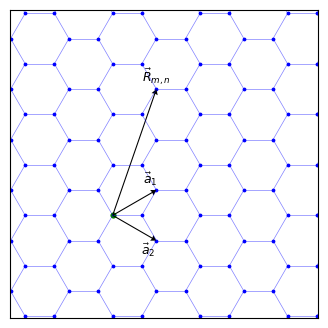

In [417]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_aspect('equal')
x1, y1, z1 = coords1.T
#x2, y2, z2 = coords2.T
#ax.scatter(x2, y2, 5, alpha = 0.5)
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])
ax.scatter(0,0,s=10, color = 'green')
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords1)):
    for j in range(i+1,len(coords1)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax.plot([x1[i], x1[j]], [y1[i], y1[j]], color='blue', lw=0.5, alpha = 0.5)
ax.scatter(x1, y1, 3, color = 'blue')
ax.scatter(0,0,s=10, color = 'green')
ax.quiver(0, 0, a1[0], a1[1], angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(a1[0]  - 0.03, a1[1] + 0.05 , r'$\vec{a}_1$', fontsize=9, ha='center', va='center', fontweight='extra bold')

ax.quiver(0, 0, a2[0], a2[1], angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(a2[0]  - 0.04, a2[1] -0.05, r'$\vec{a}_2$', fontsize=9, ha='center', va='center', fontweight='extra bold')
ax.quiver(0, 0, Ra[0], Ra[1], angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(Ra[0] , Ra[1]+0.06  , r'$\vec{R}_{m,n}$', fontsize=9, ha='center', va='center', fontweight='extra bold')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figure01.png', dpi=300, bbox_inches='tight')

In [331]:
m = 3
n = 1
L1 = m * a1 + n * a2
L2 = n * a1 + m * a2

In [332]:
import matplotlib.patches as patches

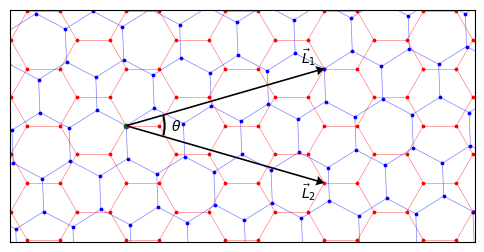

In [418]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_aspect('equal')
x1, y1, z1 = coords1.T
x2, y2, z2 = coords2.T
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-0.5,0.5])
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords1)):
    for j in range(i+1,len(coords1)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords2)):
    for j in range(i+1,len(coords2)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)
ax.scatter(x1, y1, 3, color = 'red')
ax.scatter(x2, y2, 3, color = 'blue')
ax.scatter(0, 0, s=10, color = 'green')
ax.quiver(0, 0, L1[0], L1[1], angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(L1[0] - 0.07, L1[1] + 0.05 , r'$\vec{L}_1$', fontsize=10, ha='center', va='center', fontweight='extra bold')

ax.quiver(0, 0, L2[0], L2[1] , angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(L2[0] - 0.07, L2[1] - 0.04 , r'$\vec{L}_2$', fontsize=10, ha='center', va='center', fontweight='extra bold')

# Plotting the angle arc (modified part)
angle_rad = np.arccos(np.dot(L1, L2) / (np.linalg.norm(L1) * np.linalg.norm(L2)))
angle_deg = np.degrees(angle_rad)

# Calculate the midpoint of L1 and L2
midpoint = [0.015,0]

# Align the arc with the angle between L1 and L2, starting from the midpoint
angle_arc = patches.Arc(midpoint, 0.3, 0.3,  # Center the arc at the midpoint
                         theta1=-angle_deg/2,  # Start halfway between L1 and L2
                         theta2=angle_deg/2,   # End halfway between L1 and L2
                         color='black', lw=1.5)
ax.add_patch(angle_arc)
angle_text = f'$\\theta$'
ax.set_xticks([])
ax.set_yticks([])
ax.text(midpoint[0]+ 0.2, midpoint[1] , angle_text, ha='center', va='center', color='black', fontsize=10, fontweight='extra bold')
plt.savefig('figure02.png', dpi=300, bbox_inches='tight')

In [419]:
m = 3
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
np.degrees(alpha)

32.204227503972035

In [420]:
T1 = m * a1 + n * a2
T2 = - n * a1 + (m+n) * a2

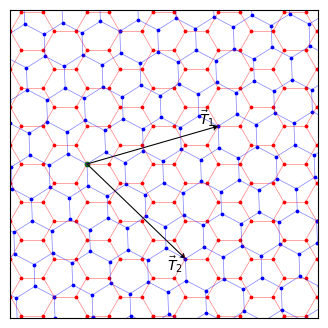

In [421]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_aspect('equal')
x1, y1, z1 = coords1.T
x2, y2, z2 = coords2.T
ax.set_xlim([-0.5,1.5])
ax.set_ylim([-1,1])
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords1)):
    for j in range(i+1,len(coords1)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords2)):
    for j in range(i+1,len(coords2)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)
ax.scatter(x1, y1, 3, color = 'red')
ax.scatter(x2, y2, 3, color = 'blue')
ax.scatter(0, 0, s=10, color = 'green')
ax.quiver(0, 0, T1[0], T1[1], angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(T1[0] - 0.07, T1[1] + 0.05 , r'$\vec{T}_1$', fontsize=10, ha='center', va='center', fontweight='extra bold')

ax.quiver(0, 0, T2[0], T2[1] , angles='xy', scale_units='xy', scale=1, color='k', width=0.0035, headwidth=6)
ax.text(T2[0] - 0.07, T2[1] - 0.04 , r'$\vec{T}_2$', fontsize=10, ha='center', va='center', fontweight='extra bold')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figure03.png', dpi=300, bbox_inches='tight')

In [387]:
m = 2
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords21 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords11 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))

R1 = m * a1 + n * a2
R2 = -n * a1 + (m+n) * a2
origin = np.array([0,0])
R4 = R1 + R2
polygon_coords = np.array([origin, R1[:-1] ,R4[:-1] ,R2[:-1]])
m = 3
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords22 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords12 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))
R1 = m * a1 + n * a2
R2 = -n * a1 + (m+n) * a2
origin = np.array([0,0])
R4 = R1 + R2
polygon_coords2 = np.array([origin, R1[:-1] ,R4[:-1] ,R2[:-1]])
m = 5
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords23 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords13 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))
R1 = m * a1 + n * a2
R2 = -n * a1 + (m+n) * a2
origin = np.array([0,0])
R4 = R1 + R2
polygon_coords3 = np.array([origin, R1[:-1] ,R4[:-1] ,R2[:-1]])


In [410]:
m = 5
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
np.degrees(alpha)

42.10344887074584

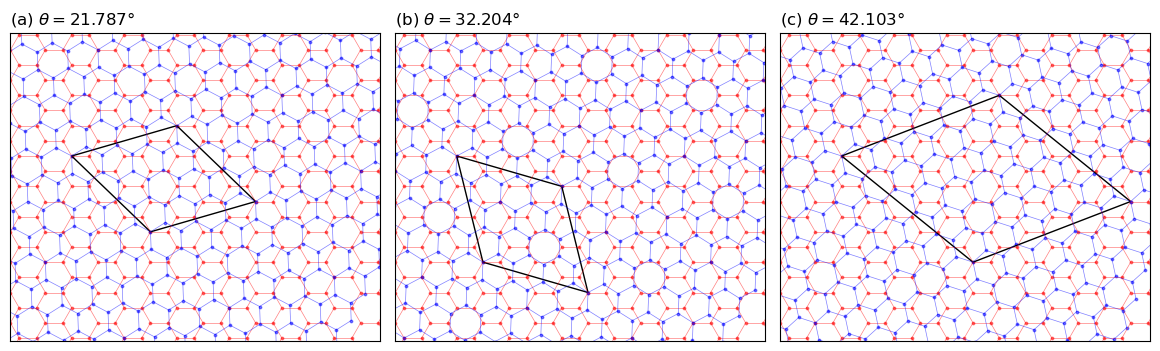

In [408]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(11.7, 8.3))

# Subfigure 1
ax1.set_aspect('equal')

ax1.set_xlim([-0.5, 2.5])
ax1.set_ylim([-1.5,1])
x1, y1, z1 = coords11.T
x2, y2, z2 = coords21.T
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords11)):
    for j in range(i+1,len(coords11)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax1.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords21)):
    for j in range(i+1,len(coords21)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax1.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax1.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax1.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon = patches.Polygon(polygon_coords, closed=True, fill=None)  
ax1.add_patch(polygon)
ax1.set_xticks([])
ax1.set_yticks([])

# Subfigure 2

ax2.set_aspect('equal')
ax2.set_xlim([-0.5, 2.5])
ax2.set_ylim([-1.5,1])
x1, y1, z1 = coords12.T
x2, y2, z2 = coords22.T
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords12)):
    for j in range(i+1,len(coords12)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax2.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords22)):
    for j in range(i+1,len(coords22)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax2.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax2.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax2.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon2 = patches.Polygon(polygon_coords2, closed=True, fill=None)  
ax2.add_patch(polygon2)
ax2.set_xticks([])
ax2.set_yticks([])
# Subfigure 3
ax3.set_aspect('equal')

ax3.set_xlim([-0.5, 2.5])
ax3.set_ylim([-1.5,1])
x1, y1, z1 = coords13.T
x2, y2, z2 = coords23.T
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords13)):
    for j in range(i+1,len(coords13)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax3.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords23)):
    for j in range(i+1,len(coords23)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax3.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax3.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax3.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon3 = patches.Polygon(polygon_coords3, closed=True, fill=None)  
ax3.add_patch(polygon3)
ax3.set_xticks([])
ax3.set_yticks([])
ax1.set_title("(a) $\\theta = 21.787 \\degree $  ", loc="left")
ax2.set_title("(b) $\\theta= 32.204 \\degree $ ", loc="left")
ax3.set_title("(c) $\\theta= 42.103 \\degree $ ", loc="left")

# Combine subplots side by side

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig('figure04.png', dpi=300, bbox_inches='tight')

In [392]:
m = 3
n = 1
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords21 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords11 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))
R1 = m * a1 + n * a2
R2 = -n * a1 + (m+n) * a2
origin = np.array([0,0])
R4 = R1 + R2
polygon_coords = np.array([origin, R1[:-1] ,R4[:-1] ,R2[:-1]])

m = 5
n = 2
cosalpha = (n**2 + 4*m*n + m**2) / (2*(n**2 + m*n + m**2))
alpha = math.acos(cosalpha)
a1_T = lattice_vectors (alpha, a1)
a2_T = lattice_vectors (alpha, a2)
a1_B = a1
a2_B = a2
c_T = lattice_vectors (alpha, c)
c_B = c
coords2a = np.array([i * a1_T + j * a2_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords2b = np.array([i * a1_T + j * a2_T + c_T + [0,0,d0] for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords22 = np.concatenate((coords2a, coords2b))
coords1a = np.array([i * a1_B + j * a2_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1) ])
coords1b = np.array([i * a1_B + j * a2_B + c_B for i in range(-nmax, nmax+1) for j in range(-nmax, nmax+1)])
coords12 = np.concatenate((coords1a, coords1b))
coordsa = np.concatenate((coords1a, coords2a))
coordsb = np.concatenate((coords1b, coords2b))
R1 = (m-n)/3 * a1 + (m+2*n)/3 * a2
R2 = -(m+2*n)/3 * a1 + (2*m+n)/3 * a2
origin = np.array([0,0])
R4 = R1 + R2
polygon_coords2 = np.array([origin, R1[:-1] ,R4[:-1] ,R2[:-1]])


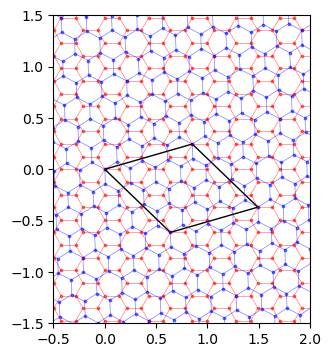

In [393]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_aspect('equal')
x1, y1, z1 = coords11.T
x2, y2, z2 = coords21.T
ax.set_xlim([-0.5,2])
ax.set_ylim([-1.5,1.5])
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords11)):
    for j in range(i+1,len(coords11)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords21)):
    for j in range(i+1,len(coords21)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon = patches.Polygon(polygon_coords, closed=True, fill=None)  
ax.add_patch(polygon)

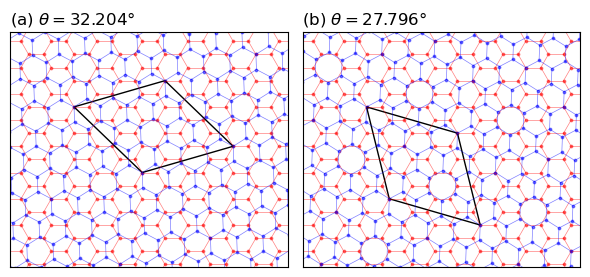

In [411]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))

# Subfigure 1
ax1.set_aspect('equal')

ax1.set_xlim([-0.6, 2])
ax1.set_ylim([-1.5,0.7])
x1, y1, z1 = coords11.T
x2, y2, z2 = coords21.T
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords11)):
    for j in range(i+1,len(coords11)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax1.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords21)):
    for j in range(i+1,len(coords21)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax1.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax1.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax1.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon = patches.Polygon(polygon_coords, closed=True, fill=None)  
ax1.add_patch(polygon)
ax1.set_xticks([])
ax1.set_yticks([])

# Subfigure 2

ax2.set_aspect('equal')
ax2.set_xlim([-0.6, 2])
ax2.set_ylim([-1.5,0.7])
x1, y1, z1 = coords12.T
x2, y2, z2 = coords22.T
limit = a0+ 0.01
# plotting the honeycomb lattice
for i in range(len(coords12)):
    for j in range(i+1,len(coords12)):
        dx = x1[j] - x1[i]
        dy = y1[j] - y1[i]
        if np.abs(dx) < limit and np.abs(dy) < limit:
            ax2.plot([x1[i], x1[j]], [y1[i], y1[j]], color='red', lw=0.5, alpha = 0.5)
for i in range(len(coords22)):
    for j in range(i+1,len(coords22)):
        dx2 = x2[j] - x2[i]
        dy2 = y2[j] - y2[i]
        if np.abs(dx2) < limit and np.abs(dy2) < limit:
            ax2.plot([x2[i], x2[j]], [y2[i], y2[j]], color='blue', lw=0.5, alpha = 0.5)

ax2.scatter(x1, y1, 3, color = 'red', alpha = 0.5)
ax2.scatter(x2, y2, 3, color = 'blue', alpha = 0.5)           
polygon2 = patches.Polygon(polygon_coords2, closed=True, fill=None)  
ax2.add_patch(polygon2)
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_title("(a) $\\theta= 32.204 \\degree $ ", loc="left")
ax2.set_title("(b) $\\theta= 27.796 \\degree $ ", loc="left")

# Combine subplots side by side

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.savefig('figure05.png', dpi=300, bbox_inches='tight')